In [1]:
from process_bigraph import ProcessTypes, Composite, register_types
from vCRM.adaptive_crm import adaptive_crm, get_adaptive_crm_emitter, plot_adaptive_crm_simulation
from process_bigraph.emitter import gather_emitter_results
import numpy as np

In [2]:
adaptive_crm_config = {
    "species_number": 2,
    "resource_number": 2,
    "death_rate": {
        "sp1": 0.1,
        "sp2": 0.1,
    },
    "adaptation_rate": {
        "sp1": 0.5,
        "sp2": 0.5,
    },
    "metabolic_capacity": {
        "sp1": 1.0,
        "sp2": 1.0,
    },
    "resource_value": {
        "R1": 1.0,
        "R2": 1.0,
    },
    "monod_constant": {
        "sp1": {"R1": 1.0, "R2": 1.0},
        "sp2": {"R1": 1.0, "R2": 1.0},
    },
    "yield_coefficient": {  # Only used for ethanol production (can be all 0s if unused)
        "sp1": {"R1": 0.0, "R2": 0.0},
        "sp2": {"R1": 0.0, "R2": 0.0},
    }
}

In [3]:
initial_state = {
    "species": {"sp1": 0.1, "sp2": 0.1},
    "concentrations": {"R1": 5.0, "R2": 5.0},
    "strategies": {
        "sp1": {"R1": 0.5, "R2": 0.5},
        "sp2": {"R1": 0.5, "R2": 0.5},
    }
}

In [4]:
adaptive_spec = {
    "adaptive_crm": {
        "_type": "process",
        "address": "local:adaptive_crm",
        "config": adaptive_crm_config,
        "inputs": {
            "species": ["species"],
            "concentrations": ["concentrations"],
            "strategies": ["strategies"],
        },
        "outputs": {
            "species_delta": ["species"],
            "concentrations_delta": ["concentrations"],
            "strategies_delta": ["strategies"],
        },
        "interval": 1.0,
    }
}

In [5]:
# Merge initial state
spec = {**adaptive_spec, **initial_state}

# Create emitter
state_keys = ["species", "concentrations", "strategies", "global_time"]
spec["emitter"] = get_adaptive_crm_emitter(state_keys)

# Register process
core = ProcessTypes()
core = register_types(core)
core.register_process("adaptive_crm", adaptive_crm)  # Make sure your class is named this

# Create and run simulation
sim = Composite({
    "state": spec,
}, core=core)

sim.run(1000)

In [6]:
results = gather_emitter_results(sim)[('emitter',)]

In [7]:
results

[{'global_time': 0.0,
  'concentrations': {'R1': 5.0, 'R2': 5.0},
  'strategies': {'sp1': {'R1': 0.5, 'R2': 0.5}, 'sp2': {'R1': 0.5, 'R2': 0.5}},
  'species': {'sp1': 0.1, 'sp2': 0.1}},
 {'global_time': 1.0,
  'concentrations': {'R1': np.float64(4.877367225375742),
   'R2': np.float64(4.877367225375742)},
  'strategies': {'sp1': {'R1': np.float64(0.5), 'R2': np.float64(0.5)},
   'sp2': {'R1': np.float64(0.5), 'R2': np.float64(0.5)}},
  'species': {'sp1': np.float64(0.20788627982226698),
   'sp2': np.float64(0.20788627982226698)}},
 {'global_time': 2.0,
  'concentrations': {'R1': np.float64(4.6247826462608295),
   'R2': np.float64(4.6247826462608295)},
  'strategies': {'sp1': {'R1': np.float64(0.5), 'R2': np.float64(0.5)},
   'sp2': {'R1': np.float64(0.5), 'R2': np.float64(0.5)}},
  'species': {'sp1': np.float64(0.4298948600432856),
   'sp2': np.float64(0.4298948600432856)}},
 {'global_time': 3.0,
  'concentrations': {'R1': np.float64(4.113358509190014),
   'R2': np.float64(4.1133585091

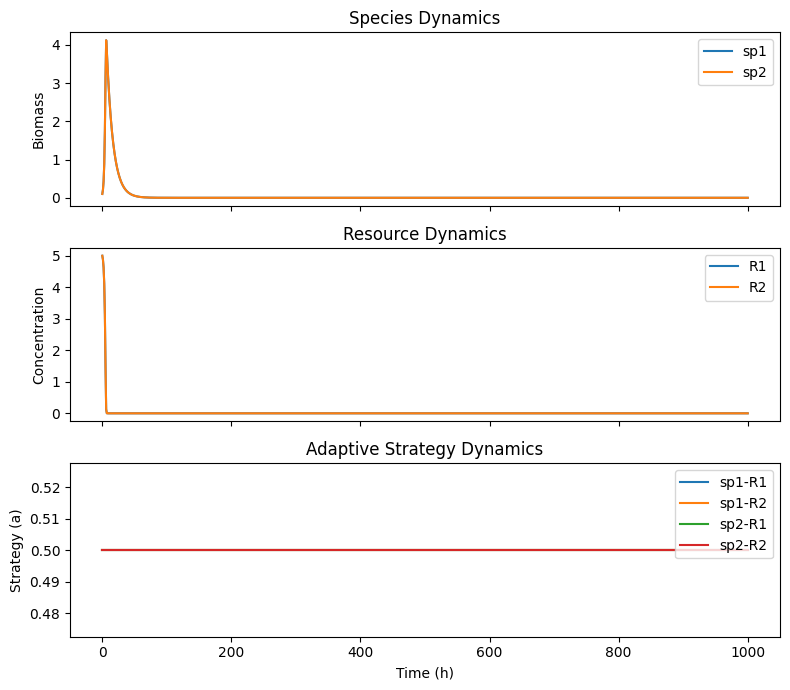

In [8]:
plot_adaptive_crm_simulation(results)

In [9]:
# Single-species (original diauxic shift) 
params_single = {
    'v_gal': 1.20e10,
    'v_eth': 1.25e10,
    'K_gal': 1.e-3,
    'K_eth': 9.67e-3,
    'Y': 0.53,
    'Q': 2.18e-5,
    'delta': 2.15e-6,
    'd': 2.0e-6,
}

initial_conditions_single = [1e6, 5e-3, 0.0, 1.25e-11, 4.75e-12]
t = np.linspace(0, 71, 1000)

In [10]:
adaptive_crm_config = {
    "species_number": 1,
    "resource_number": 2,
    "adaptation_rate": {"sp1": params_single['d']},
    "death_rate": {"sp1": params_single['delta']},
    "metabolic_capacity": {"sp1": params_single['Q']},
    "resource_value": {"gal": params_single['v_gal'], "eth": params_single['v_eth']},
    "monod_constant": {"sp1": {"gal": params_single['K_gal'], "eth": params_single['K_eth']}},
    "yield_coefficient": {"sp1": {"gal": params_single['Y'], "eth": 0.0}},  # Assume no further ethanol yield
}

In [11]:
initial_state = {
    "species": {"sp1": initial_conditions_single[0]},
    "concentrations": {
        "gal": initial_conditions_single[1],
        "eth": initial_conditions_single[2]
    },
    "strategies": {
        "sp1": {
            "gal": initial_conditions_single[3],
            "eth": initial_conditions_single[4]
        }
    }
}

In [12]:
adaptive_crm_spec = {
    "adaptive_crm": {
        "_type": "process",
        "address": "local:adaptive_crm",
        "config": adaptive_crm_config,
        "inputs": {
            "species": ["species"],
            "concentrations": ["concentrations"],
            "strategies": ["strategies"]
        },
        "outputs": {
            "species_delta": ["species"],
            "concentrations_delta": ["concentrations"],
            "strategies_delta": ["strategies"]
        },
        "interval": 0.1,
    }
}

In [13]:
# Merge everything into one full spec
full_spec = {
    **adaptive_crm_spec,
    **initial_state,
    "emitter": get_adaptive_crm_emitter(["species", "concentrations", "strategies", "global_time"])
}

In [14]:
# Register process
core = ProcessTypes()
core = register_types(core)
core.register_process("adaptive_crm", adaptive_crm)  # Make sure your class is named this

# Create and run simulation
sim = Composite({
    "state": full_spec,
}, core=core)

sim.run(71)

In [15]:
results = gather_emitter_results(sim)[('emitter',)]

In [16]:
results

[{'global_time': 0.0,
  'concentrations': {'gal': 0.005, 'eth': 0.0},
  'strategies': {'sp1': {'gal': 1.25e-11, 'eth': 4.75e-12}},
  'species': {'sp1': 1000000.0}},
 {'global_time': 0.1,
  'concentrations': {'gal': np.float64(0.0049989495432766744),
   'eth': np.float64(0.0)},
  'strategies': {'sp1': {'gal': np.float64(1.2553864785763552e-11),
    'eth': np.float64(4.75e-12)}},
  'species': {'sp1': np.float64(1012605.2643286354)}},
 {'global_time': 0.2,
  'concentrations': {'gal': np.float64(0.004997881270762709),
   'eth': np.float64(0.0)},
  'strategies': {'sp1': {'gal': np.float64(1.2607959769697627e-11),
    'eth': np.float64(4.75e-12)}},
  'species': {'sp1': np.float64(1025424.3154119039)}},
 {'global_time': 0.30000000000000004,
  'concentrations': {'gal': np.float64(0.0049967948228548205),
   'eth': np.float64(0.0)},
  'strategies': {'sp1': {'gal': np.float64(1.266228589389677e-11),
    'eth': np.float64(4.75e-12)}},
  'species': {'sp1': np.float64(1038461.4684427985)}},
 {'globa

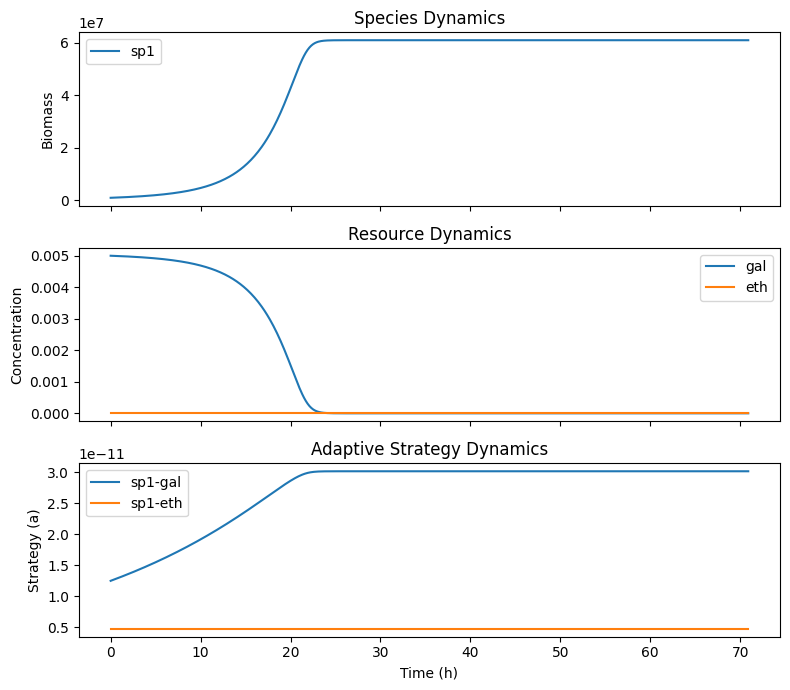

In [17]:
plot_adaptive_crm_simulation(results)